# Tensorflow 모듈 활용
tf 모듈을 활용하는 것을 배우는 단계

# tf.data 모듈
- 데이터 입력 파이프라인을 위한 모듈
    - 모델 학습/평가를 위한 데이터셋을 제공(feeding)하기 위한 모듈
   - raw dataset 에서 입력을 위한 **전처리**, **배치 크기 조정**, **shuffling**등을 한번에 처리할 수 있게 한다.
- tf.data.Dataset 추상클래스에서 상속된 여러가지 클래스들을 제공
    - 입력 소스의 제공 형태, 어떤 처리를 하는지에 따라 다양한 하위클래스들이 제공된다.
    
> 파이프라인의 핵심! : <font size=5><span style="background-color:#fff5b1">**데이터가 흘러가는 것.**</span></font>

## Dataset API 사용
1. **Dataset 생성**
    - raw dataset을 지정 (Loading)
    - from_tensor_slices(), from_generator() 클래스 메소드, tf.data.TFRecordDataset 클래스등를 사용해 메모리나 파일에 있는 데이터를 Dataset으로 만든다.
    - <font size=5><span style="background-color:#fff5b1">**from_tensor_slices()**</span></font>: 메모리의 리스트, 넘파이배열, 텐서플로 자료형에서 데이터를 생성한다.

2. **제공 데이터 전처리**
    - **map(함수)**: Dataset이 제공하는 원소를 처리해서 변환된 원소를 제공하도록 한다.
        - 함수: 원소를 어떻게 변환할 지 정의한 함수를 매개변수로 전달한다.
            - 매개변수: Dataset이 제공하는 원소를 받을 변수. 
            - 반환값: Dataset이 제공한 원소를 변경처리한 값.
    - **filter(함수)**: Dataset이 제공하는 원소중 특정 조건을 만족하는(True)인 원소들만 제공한다.
        - 함수: 원소가 특정조건을 만족하는지 여부를 확인하는 로직을 정의한 함수를 매개변수로 전달한다.
            - 매개변수: Dataset이 제공하는 원소를 받을 변수.
            - 반환값: Dataset이 제공한 원소가 특정조건을 만족하는지 여부(bool)

3. **데이터 제공 설정 관련**
    - **batch(size)**: 학습/평가시 한번에 제공할 batch size 지정
        - size: int. batch size 지정
        - drop_remainder: bool. True일 경우 마지막 제공시 남은 데이터수가 batch size보다 작으면 제공하지 않는다.
    - **shuffle(buffer 크기)**: dataset의 원소들의 순서를 섞는다. 
        - buffer 크기: int. buffer 크기는 섞는 공간의 크기로  **데이터보다 크거나 같으면** 완전셔플, **적으면 일부만 가져와서 섞어** 완전셔플이 안된다.
        - 데이터 사이즈가 너무 커서 메모리가 부족할 경우 버퍼크기를 적게 준다.
        - 메모리가 충분하다면 데이터의 개수와 동일하게 주면된다.
    - **repeat(count)**: 전체 데이터를 한번 다 제공한 뒤 다시 데이터를 제공한다.
        - count: 몇번 제공할지 반복 횟수
        - shuffle이 적용된 Dataset의 경우 다음 반복 제공마다 shuffle을 진행한다. (에폭단위)
        

- 각 tf.data 함수들은 각 기능에 맞게 데이터를 처리하는 Dataset 객체를 반환한다.

### Dataset 메소드
- take(개수): 지정한 개수만큼의 데이터만 제공한다.

In [178]:
import tensorflow as tf
import numpy as np

##### Tensor Type
>- TensorFlow의 기본 data 자료구조.
>- numpy가 ndarray를 이용해 데이터를 관리하듯이 tensorflow를 `Tensor`를 이용해 데이터를 관리한다.
>    - Tesorflow의 모델이 학습, 평가할 때 사용하는 데이터 셋(train dataset, validation dataset, test dataset)은 tf.Tensor 타입이어야 한다.
>        - 학습/평가(model.fit(), model.evaluate()) 할 때 <u>ndarray를 입력 데이터셋으로 넣어주면 **내부적으로 tf.Tensor로 변형**해서 처리.</u>
>        - **tf.Tensor는 데이터셋을 ndarray로 가지고 있다.**

In [3]:
t = tf.constant([1,2,3], dtype='float32')
t
# constant() 메서드로 만듦.

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [4]:
t.shape, t.dtype

(TensorShape([3]), tf.float32)

In [8]:
# Tensor -> ndarray로 변환
a = t.numpy()
a, type(a)

(array([1., 2., 3.], dtype=float32), numpy.ndarray)

In [18]:
# ndarray/list => Tensor
b=tf.constant(np.arange(10))
b, type(b)

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])>,
 tensorflow.python.framework.ops.EagerTensor)

In [19]:
tf.convert_to_tensor(a)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

## Dataset 예제

In [98]:
# 0 ~ 9 정수 => input data
raw_data1 = np.arange(10)
raw_data1

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [99]:
# DataSet 을 생성 -> 대상 raw dataset이 메모리에 있는 ndarray일 경우
# => Raw dataset 으로부터 데이터를 읽어들이는 기능을 제공하는 Dataset 생성.
# 원본 데이터(raw data)가 어디에 어떤 식으로 저장되어있는 지에 따라 다르다.
## 이번 경우에는 메모리에 ndarray 형식으로 저장되어 있는 데이터를 읽어 들이는 경우로,
### tf.data.Dataset.from_tensor_slices()를 통해 읽어 들였다.
#### 다른 경우도 살펴 봐야한다.

dataset = tf.data.Dataset.from_tensor_slices(raw_data1)
print(type(dataset))

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>


In [29]:
dataset[0]

TypeError: '_TensorSliceDataset' object is not subscriptable

In [30]:
# Dataset은 Iterable타입
## 그러나 Dataset은 subscriptable 이 아니기 때문에 index로 조회는 불가능하다.
### 반환 tf.Tensor 타입

for data in dataset:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [35]:
for data in dataset.take(5):  # dataset에서 5개만 조회
    print(data)
    
# dataset.take() 메서드는 지정한 개수만큼 앞에서부터 가져온다.

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### tf.Tensor 타입으로 선언된 Dataset에는 순서 존재.
<br><span style="background-color:#fff5b1">"tf모듈" 에서 "__getitems()__" 매직 메서드 를 구현하지 않아 **"not subscriptable"**</span>
- 기본적으로 Tensor는 ndarray타입을 가지고 있기 때문에 순서, index가 존재한다.
- 그러나, `tf모듈` 에서 `__getitems()__` 매직 메서드 를 구현되지 않아 [index] 로 조회 시 **"not subscriptable"** 에러가 뜬다.

##### x, y 묶어서 제공
- 두개 이상의 데이터셋을 묶어서 제공할 경우 Tuple로 묶어준다.
    - Dataset이 feeding 할 때는 같은 index의 값들을 tuple로 묶어서 제공 (zip()과 동일)

In [36]:
raw_data2 = np.arange(10, 20)
print(raw_data1, len(raw_data1))   # X
print(raw_data2, len(raw_data2))   # y

[0 1 2 3 4 5 6 7 8 9] 10
[10 11 12 13 14 15 16 17 18 19] 10


In [46]:
# 학습 - model.fit(X_train, y_train,...)
## Dataset으로 만들기 : 튜플로 묶어서 생성.     
### X: 0 -> y: 10
### X: 1 -> y: 11
### ... X:9 -> y:19 이렇게 튜플로 묶여서 각각의 X,y 가 매칭되어서 Dataset이 생성됨.

#                                               (   X           y   )
dataset2 = tf.data.Dataset.from_tensor_slices( (raw_data1, raw_data2) )
for data in dataset2.take(3):  # 두 dataset(raw_data1, raw_data2)의 같은 index의 값들을 묶어서 튜플로 반환.
    print(data)

(<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(), dtype=int32, numpy=10>)
(<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=11>)
(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=12>)


In [39]:
for X, y in dataset2:
    print(X, y, sep=' ====== ')

tf.Tensor(0, shape=(), dtype=int32) ====== tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32) ====== tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32) ====== tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32) ====== tf.Tensor(13, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32) ====== tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32) ====== tf.Tensor(15, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32) ====== tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32) ====== tf.Tensor(17, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32) ====== tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32) ====== tf.Tensor(19, shape=(), dtype=int32)


##### shuffle
- 데이터셋을 섞는다.

In [45]:
for data in dataset:
    print(data)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [131]:
raw_data1 = np.arange(10)
dataset = tf.data.Dataset.from_tensor_slices(raw_data1)
# 기존 Dataset객체.기능추가메서드() => 기존 데이터 파이프라인에 기능을 추가.

dataset3 = dataset.shuffle(10) # shuffle() : 데이터를 제공하기 전에 섞는다. (순서를 랜덤하게 바꿈)
                               # shuffle(10), 10: raw data를 섞기 위한 임시 저장소(buffer)의 크기
                       # (메모리가 허용한다면) buffer size는 총 데이터 개수에 맞춰주는 것이 제일 좋다.

print(type(dataset3))          

<class 'tensorflow.python.data.ops.shuffle_op._ShuffleDataset'>


In [129]:
for data in dataset3: # dataset3 -> shuffle로 이루어져 있기 때문에 실행할 때마다 순서가 계속 바뀐다.
    print(data)
    
# 실제로는 Buffer(임시 저장소)를 활용해, shuffle(i), i의 크기 만큼 buffer에 데이터들이 순서대로 저장되고, 
# 이 안에서 shuffle(섞기) 진행되고 다음 단계로 섞인 데이터를 전달한다.
## 원본 데이터로부터 데이터를 읽어 들이고, buffer에서 shuffle을 통해 데이터를 조작하고 모델에 전달한다.

tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


##### batch
- drop_remainder: boolean(기본 default-False)
    - batch로 제공할 데이터의 개수가 설정한 batch_size 보다 적으면 제공하지 않는다.
    - Train dataset을 만들때 True로 설정하여 항상 일정한 batch size로 학습할 수 있도록 한다. drop 되는 데이터는 다른 epoch을 반복할 때 사용된다.

In [137]:
dataset4 = dataset.batch(5)   # batch size 설정 => 반복시 지정한 개수만큼 한번에 제공.
# dataset4 = dataset.batch(10)
# dataset4 = dataset.batch(7)
print(type(dataset4))
for data in dataset4:
    print(data)

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int32)


In [140]:
# 읽어올 데이터의 개수가 batch_size보다 적으면 제공하지 않는다.
dataset5 = dataset.batch(3, drop_remainder=True) 
for data in dataset5:
    print(data)

# 0~9 까지의 dataset 을 batch(3) 통해 3개씩 묶는다면
## 012 / 345 / 678 / 9 이렇게 나뉜다.
### 그런데 drop_remainder=True를 하면 3보다 작은 데이터에 대해서 제공하지 않는 것이므로
#### 마지막 '9'는 drop 시켜 dataset5에 할당된다.

tf.Tensor([0 1 2], shape=(3,), dtype=int32)
tf.Tensor([3 4 5], shape=(3,), dtype=int32)
tf.Tensor([6 7 8], shape=(3,), dtype=int32)


##### repeat

In [141]:
dataset6 = dataset.repeat(5)  # 지정한 횟수만큼 데이터를 반복해서 제공한다. (default: 1 - 한번)
print(type(dataset6))
for data in dataset6:
    print(data)

<class 'tensorflow.python.data.ops.repeat_op._RepeatDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf

In [153]:
dataset7 = tf.data.Dataset.from_tensor_slices(raw_data1).shuffle(10).batch(3,drop_remainder=True).repeat(3) 
                                                # 데이터셋을 반복할때 마다 shuffle
for data in dataset7:
    print(data)

tf.Tensor([7 9 0], shape=(3,), dtype=int32)
tf.Tensor([4 5 6], shape=(3,), dtype=int32)
tf.Tensor([3 2 1], shape=(3,), dtype=int32)
tf.Tensor([7 5 1], shape=(3,), dtype=int32)
tf.Tensor([2 6 3], shape=(3,), dtype=int32)
tf.Tensor([0 9 8], shape=(3,), dtype=int32)
tf.Tensor([8 5 4], shape=(3,), dtype=int32)
tf.Tensor([2 7 6], shape=(3,), dtype=int32)
tf.Tensor([9 0 1], shape=(3,), dtype=int32)


##### map

In [171]:
# map - 값을 변환해서 저장한다.
## 함수 구문 : 매개변수-원소 한개를 받는다, 반환: 변환된 값을 반환.

dataset8 = dataset.map(lambda x: x * 2)
print(type(dataset8))
for data in dataset8:
    print(data)

<class 'tensorflow.python.data.ops.map_op._MapDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)


In [159]:
for i in dataset2:
    print(i)

(<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(), dtype=int32, numpy=10>)
(<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=11>)
(<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=12>)
(<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=13>)
(<tf.Tensor: shape=(), dtype=int32, numpy=4>, <tf.Tensor: shape=(), dtype=int32, numpy=14>)
(<tf.Tensor: shape=(), dtype=int32, numpy=5>, <tf.Tensor: shape=(), dtype=int32, numpy=15>)
(<tf.Tensor: shape=(), dtype=int32, numpy=6>, <tf.Tensor: shape=(), dtype=int32, numpy=16>)
(<tf.Tensor: shape=(), dtype=int32, numpy=7>, <tf.Tensor: shape=(), dtype=int32, numpy=17>)
(<tf.Tensor: shape=(), dtype=int32, numpy=8>, <tf.Tensor: shape=(), dtype=int32, numpy=18>)
(<tf.Tensor: shape=(), dtype=int32, numpy=9>, <tf.Tensor: shape=(), dtype=int32, numpy=19>)


In [170]:
# 두개의 dataset(x,y)을 묶은 Dataset객체
def map_func(x, y):
    return x**2, y   # X는 제곱, y는 그대로 반환.

# dataset9 = dataset2.map(map_func)
dataset9 = dataset2.map(lambda i,j: (i**2, j+10)) 
                            # lambda로 두개이상의 변수를 적용할 경우, 튜플로 묶어서 변환식 적용한다.
for x, y in dataset9:
    print(x, y)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(20, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32) tf.Tensor(21, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32) tf.Tensor(22, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32) tf.Tensor(23, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32) tf.Tensor(24, shape=(), dtype=int32)
tf.Tensor(25, shape=(), dtype=int32) tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(36, shape=(), dtype=int32) tf.Tensor(26, shape=(), dtype=int32)
tf.Tensor(49, shape=(), dtype=int32) tf.Tensor(27, shape=(), dtype=int32)
tf.Tensor(64, shape=(), dtype=int32) tf.Tensor(28, shape=(), dtype=int32)
tf.Tensor(81, shape=(), dtype=int32) tf.Tensor(29, shape=(), dtype=int32)


##### filter

In [173]:
# filter - 특정조건을 만족하는 원소들만 제공
## 함수구문 - 매개변수: 원소를 받을 변수, 반환: bool(True인 원소만 제공)
def filter_func(x):
    return x % 2 == 0  # 2의 배수: True

# dataset11 = dataset.filter(filter_func)
dataset11 = dataset.filter(lambda x : x%2==0)

print(type(dataset11))
for data in dataset11:
    print(data)

<class 'tensorflow.python.data.ops.filter_op._FilterDataset'>
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


# 문제 유형별 MLP 네트워크
- MLP(Multi Layer Perceptron), ANN(Artificial Neural Network), DNN (Deep Neural Network)
    - Fully Connected Layer(Dense)로 구성된 네트워크

# Regression(회귀)

## Boston Housing Dataset
보스턴 주택가격 dataset은 다음과 같은 속성을 바탕으로 해당 타운 주택 가격의 중앙값을 예측하는 문제.
- CRIM: 범죄율
- ZN: 25,000 평방피트당 주거지역 비율
- INDUS: 비소매 상업지구 비율
- CHAS: 찰스강에 인접해 있는지 여부(인접:1, 아니면:0)
- NOX: 일산화질소 농도(단위: 0.1ppm)
- RM: 주택당 방의 수
- AGE: 1940년 이전에 건설된 주택의 비율
- DIS: 5개의 보스턴 직업고용센터와의 거리(가중 평균)
- RAD: 고속도로 접근성
- TAX: 재산세율
- PTRATIO: 학생/교사 비율
- B: 흑인 비율
- LSTAT: 하위 계층 비율
<br><br>
- **Target**
    - MEDV: 타운의 주택가격 중앙값(단위: 1,000달러)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # layers.Dense()
# from tensorflow.keras.layers import Dense, ReLU,...


import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
## 여러 유형의 X, input data를 각 weight를 곱해, 하나의 값으로 추론하는 과정을 한다.
## => 선형회귀, 이는 각 feature 간의 scale이 매우 중요하기 때문에
### (Standard)Scaling 과정을 포함시킨다!

import random

In [2]:
# random seed값 설정
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)

##### 데이터 로딩

In [3]:
(train_X, y_train), (test_X, y_test) = keras.datasets.boston_housing.load_data()
print(train_X.shape, y_train.shape)
print(test_X.shape, y_test.shape)

(404, 13) (404,)
(102, 13) (102,)


In [90]:
print(train_X[0])
print(y_train[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


##### 하이퍼파라미터, 변수 정의

In [6]:
#하이퍼파라미터 변수

# 학습율 => 경사하강법에서 구한 gradient(경사-미분계수)에 곱해주는 값으로 0 ~ 1 사이 실수를 지정한다. 
## optimizer 생성때 설정.

LEARNING_RATE = 0.001  
N_EPOCH = 200 # 에폭수
N_BATCH = 400 # Train 배치사이즈
N_BATCH_VAL = 50 # Validation/evaluation 배치 사이즈. ==> 교차검증 폴더 데이터 수.

##### X, y 전처리
- MLP는 선형모델을 기반으로 하므로 Feature scaling을 해준다.

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

##### Dataset 생성

- validation/test set의 pipe line은 동일하게 구성한다.
- train dataset은 shuffle을 추가하고 batch에 drop_remainder=True를 설정한다.
- map, filter 를 pipe line에 추가할 경우 train/validation/test set에 모두 동일하게 적용한다.

In [8]:
X_train.shape[0]

404

In [9]:
## X_train, y_train ==> ndarray 메모리 저장된 데이터 ==> from_tensor_slices()로 읽어드림.

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                               .shuffle(X_train.shape[0])\
                               .batch(N_BATCH, drop_remainder=True)

# .from_tensor_slices() => 메모리의 nadrray 형태의 원본 데이터를 연결시킴.
# .shuffle(X_train.shape[0]) => 에폭별로 데이터를 랜덤하게 순서 섞기
# .batch(N_BATCH, drop_remainder=True) => 지정된 개수만큼 한번에 모델에 제공


test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH_VAL)

In [10]:
# 에폭(epoch) 당 step 수 : 전체 데이터 셋 한번 학습할 때 파라미터 업데이트를 몇 번 하는지. 

# drop_remainder = True - 전체 데이터 수 // batch size (몫 연산, 나머지는 버림.)
# drop_remainder = False - ceil(전체 데이터 수 / batch size) (나머지 올림, 버리지 않고 업데이트를 한번 더 함.)

print('에폭당 step수:', len(train_dataset)) # drop_remainder = True
print('에폭당 step수:', len(test_dataset)) # drop_remainder = False

에폭당 step수: 1
에폭당 step수: 3


##### 모델 구현

1. 모델 객체 생성 - Sequential
2. 모델에 Layer들 추가
    - Input Layer 추가
        - 입력 데이터의 shape을 지정한다.
        1. InputLayer 객체를 생성해서 추가한다.
        2. 첫번째 Hidden Layer에 input_shape 매개변수에 shape을 지정하여 추가한다.
    - Hidden Layer들 추가
        - Layer의 개수와 Layer의 Unit의 개수는 튜닝대상으로 성능에 영향을 준다.
        - 활성함수는 ReLU 를 사용한다.
        - Layer의 개수와 Unit 개수가 많을 수록 복잡한 모델, 적을 수록 단순한 모델이된다.
    - Output Layer 추가
        - 풀려는 문제에 따라 unit개수와 활성함수를 지정한다.

In [11]:
help(keras.optimizers.Adam)

## Adam의 learning_rate : default 값이 0.001 임을 확인할 수 있다.

Help on class Adam in module keras.src.optimizers.adam:

class Adam(keras.src.optimizers.optimizer.Optimizer)
 |  Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, weight_decay=None, clipnorm=None, clipvalue=None, global_clipnorm=None, use_ema=False, ema_momentum=0.99, ema_overwrite_frequency=None, jit_compile=True, name='Adam', **kwargs)
 |  
 |  Optimizer that implements the Adam algorithm.
 |  
 |  Adam optimization is a stochastic gradient descent method that is based on
 |  adaptive estimation of first-order and second-order moments.
 |  
 |  According to
 |  [Kingma et al., 2014](http://arxiv.org/abs/1412.6980),
 |  the method is "*computationally
 |  efficient, has little memory requirement, invariant to diagonal rescaling of
 |  gradients, and is well suited for problems that are large in terms of
 |  data/parameters*".
 |  
 |  Args:
 |    learning_rate: A `tf.Tensor`, floating point value, a schedule that is a
 |      `tf.keras.optimizers.sched

In [10]:
def get_model_boston(lr=0.01):
    model = keras.Sequential() # 빈 모델 생성
    
    # 다음 과정에서 빈 모델에 레이어들을 추가.
    
    # input layer => input data 의 shape만 알려주는 것이기 때문에
    ## 첫번째 히든 레이어, Dense 의 파라미터에 input_shape()을 지정해서 사용해도 된다.
    ### 따로 input layer를 추가하지 않아도 된다.
    
    # Dense 내에서 activation='relu' 를 통해 활성함수를 추가할 수 있다.
##    model.add(keras.layers.ReLU()) 이를 생략하고 파라미터 형식으로 추가가 가능하다.
    ### 경우에 따라 Dense와 activation 사이의 동작이 필요하다면 따로 선언해야하는 경우도 있을 수 있다.
    
    # Dense layer의 경우 : unit의 개수를 줄여 나간다. '32->16->8', 보통 절반 단위로 줄여 나감.
    model.add(layers.Dense(units=32, activation='relu', input_shape=(13, )))
    model.add(layers.Dense(units=16, activation='relu'))
    model.add(layers.Dense(units=8, activation='relu'))
    
    # output layer
    ## unit 개수 : 모델이 추정하려는 값의 개수에 맞춰서 설정. : 현재 문제 - 집 값을 맞춘다 -> 1
    ### activation 함수 : 일반적으로 생략 - default : None
    ###                 : 예외 - 값의 범위가 정해져 있고 범위 값을 출력하는 함수가 있을 경우 그 함수를 사용
    ###                    ex) 0 ~ 1 : sigmoid, -1 ~ 1 : tanh
    model.add(layers.Dense(units=1)) # y의 shape이 1이기 때문에 (units = 1)
    
    # 컴파일 - optimizer, loss function 은 필수! / metrics 선택사항.
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  ## optimizer를 default값으로 생성할 것을 사용할 경우 문자열로 지정. ("adam") => optimizer='adam'
    
                  loss='mse') # 회귀 문제의 경우, loss를 보통 "mse" 사용.

    return model

In [11]:
def get_model_boston_2(lr=0.01):
    model = keras.Sequential([
        layers.Dense(32,activation='relu',input_shape=(13,)),
        layers.Dense(16,activation='relu'),
        layers.Dense(8,activation='relu'),
        layers.Dense(1),
    ])
    ## 위의 함수를 한번에 리스트 형식으로 선언
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

In [12]:
model_boston = get_model_boston() # 컴파일된 모델을 반환

# 딥러닝 모델의 구조 확인
model_boston.summary()

## 각 Dense의 output shape가 정해지는 원리를 알아야 한다.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1121 (4.38 KB)
Trainable params: 1121 (4.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


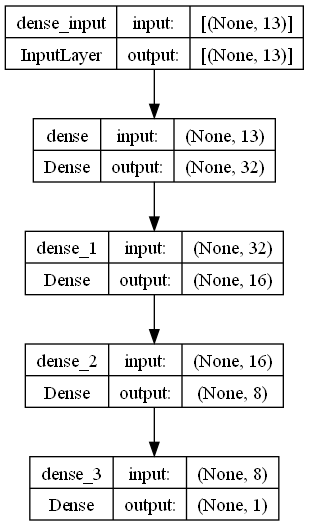

In [64]:
keras.utils.plot_model(model_boston, show_shapes=True,to_file='model_boston.png')

##### 학습(Train)

In [26]:
# train_dataset 생성->X, y를 제공
hist = model_boston.fit(train_dataset, ### (X_train, y_train) + shuffle + batch_size
                        epochs=N_EPOCH, 
                        validation_data=test_dataset # Dataset을 이용할 경우 validation_split을 사용할 수 없다.
                        )

Epoch 1/200
1/1 [==============================] - 0s 23ms/step - loss: 3.6040 - val_loss: 12.1127
Epoch 2/200
1/1 [==============================] - 0s 19ms/step - loss: 3.5749 - val_loss: 12.0653
Epoch 3/200
1/1 [==============================] - 0s 12ms/step - loss: 3.6162 - val_loss: 11.9940
Epoch 4/200
1/1 [==============================] - 0s 18ms/step - loss: 3.6043 - val_loss: 11.9788
Epoch 5/200
1/1 [==============================] - 0s 18ms/step - loss: 3.6043 - val_loss: 12.0021
Epoch 6/200
1/1 [==============================] - 0s 18ms/step - loss: 3.5226 - val_loss: 12.0353
Epoch 7/200
1/1 [==============================] - 0s 19ms/step - loss: 3.5712 - val_loss: 12.0607
Epoch 8/200
1/1 [==============================] - 0s 17ms/step - loss: 3.5372 - val_loss: 12.1030
Epoch 9/200
1/1 [==============================] - 0s 18ms/step - loss: 3.5718 - val_loss: 12.1103
Epoch 10/200
1/1 [==============================] - 0s 16ms/step - loss: 3.5463 - val_loss: 12.0480
Epoch 11/

1/1 [==============================] - 0s 16ms/step - loss: 3.0950 - val_loss: 11.6560
Epoch 84/200
1/1 [==============================] - 0s 17ms/step - loss: 3.0238 - val_loss: 11.6158
Epoch 85/200
1/1 [==============================] - 0s 16ms/step - loss: 3.0811 - val_loss: 11.5991
Epoch 86/200
1/1 [==============================] - 0s 17ms/step - loss: 3.0616 - val_loss: 11.6059
Epoch 87/200
1/1 [==============================] - 0s 17ms/step - loss: 3.0560 - val_loss: 11.6686
Epoch 88/200
1/1 [==============================] - 0s 16ms/step - loss: 3.0144 - val_loss: 11.6721
Epoch 89/200
1/1 [==============================] - 0s 19ms/step - loss: 3.0354 - val_loss: 11.6089
Epoch 90/200
1/1 [==============================] - 0s 19ms/step - loss: 3.0081 - val_loss: 11.5802
Epoch 91/200
1/1 [==============================] - 0s 16ms/step - loss: 3.0455 - val_loss: 11.5871
Epoch 92/200
1/1 [==============================] - 0s 27ms/step - loss: 3.0226 - val_loss: 11.6533
Epoch 93/200


##### 결과 시각화
- 학습 시 epoch별 검증 결과를 시각화한다.

In [15]:
hist.history.keys()

dict_keys(['loss', 'val_loss'])

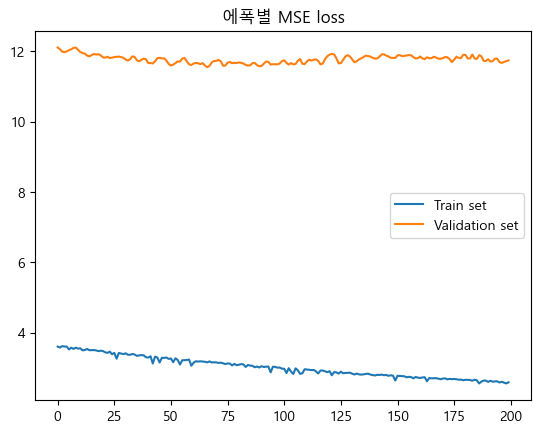

In [28]:
# hist.history : 에폭별 검증 결과
# hist.epoch : 에폭리스트
plt.plot(hist.epoch, hist.history['loss'], label='Train set')
plt.plot(hist.epoch, hist.history['val_loss'], label='Validation set')

plt.title('에폭별 MSE loss')
# plt.ylim(0, 30) # y 값의 범위 0 ~ 30 줄임. (값의변화가 클 때 변화율을 확인)
plt.legend()
plt.show()

# 성능이 개선되는 추세에서 멈췄으므로 epoch을 크게 잡고 학습해야한다.
## 모델 fit을 계속할수록, 성능이 좋아진다.

##### 최종 테스트

In [30]:
loss = model_boston.evaluate(test_dataset)

3/3 [==============================] - 0s 2ms/step - loss: 11.7447


In [31]:
loss

11.744736671447754

Dense units가 처음에 정해지는원리는???

model.fit()을 하면할수록 결과값이 더 좋아지는데, 이것은 새롭게 처음부터 학습하는것이 아닌, 이전의 학습 내용을 기억하고 학습하는 것인가??


##### 모델 네트워크 저장

In [40]:
import os
os.getcwd()

'C:\\workspace\\Bootcamp_DeepLearning'

In [41]:
# 저장 시, 경로에 한글이 있으면 안됨.

path = 'saved_model' # 모든 모델들을 저장할 디렉토리 경로
os.makedirs(path, exist_ok=True) # 없으면 디렉토리 생성, 있으면 생성안하고 그대로 사용.
saved_dir = os.path.join(path, 'boston_model') # boston dataset을 학습한 모델을 저장할 디렉토리

In [88]:
saved_dir

'saved_model\\boston_model'

In [43]:
# 모델 저장 => 저장할 디렉토리를 문자열로 전달
model_boston.save(saved_dir)

INFO:tensorflow:Assets written to: saved_model\boston_model\assets


INFO:tensorflow:Assets written to: saved_model\boston_model\assets


##### 새로운 데이터 추론

In [94]:
# 저장된 모델을 불러와서 추론
saved_model = keras.models.load_model(saved_dir) # 모델이 저장된 디렉토리 경로 전달
saved_model.evaluate(test_dataset)

3/3 [==============================] - 0s 2ms/step - loss: 11.7447


11.744736671447754

In [95]:
X_new = X_test[:5]
# 추론 : model.predict(X)

pred = saved_model.predict(X_new)
print(pred) # 추론한 y 값.

1/1 [==============================] - 0s 41ms/step
[[ 8.248606]
 [17.944342]
 [21.531223]
 [30.60721 ]
 [23.250153]]


In [96]:
y_test[:5] # 정답 y 값.

array([ 7.2, 18.8, 19. , 27. , 22.2])

# 분류 (Classification)

## Fashion MNIST Dataset - 다중분류(Multi-Class Classification) 문제

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋. 
이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 의류 품목을 나타낸다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

이미지는 28x28 크기이며 Gray scale이다. *레이블*(label)은 0에서 9까지의 정수 배열이다. 아래 표는 이미지에 있는 의류의 **클래스**(class)들이다.

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trousers</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

각 이미지는 하나의 레이블에 매핑되어 있다. 데이터셋에 클래스 이름이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장한다.

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import numpy as np
import matplotlib.pyplot as plt

import os
import random

# seed 값 설정
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [48]:
class_names = np.array(['T-shirt/top', 'Trousers', 'Pullover', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

##### Data 로딩

In [49]:
(train_image, y_train), (test_image, y_test) = keras.datasets.fashion_mnist.load_data()
train_image.shape, y_train.shape, test_image.shape, y_test.shape

4422102/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [50]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
       dtype=int64))

##### validatation dataset set  분리
- Train set을 Train/validation set으로 분리

Test set은 위에서 이미 분리된 상태.

In [51]:
from sklearn.model_selection import train_test_split
train_image, val_image, y_train, y_val = train_test_split(train_image,
                                                          y_train, 
                                                          test_size=0.2, 
                                                          stratify=y_train, 
                                                          random_state=0)
train_image.shape, val_image.shape

((48000, 28, 28), (12000, 28, 28))

##### 이미지 확인

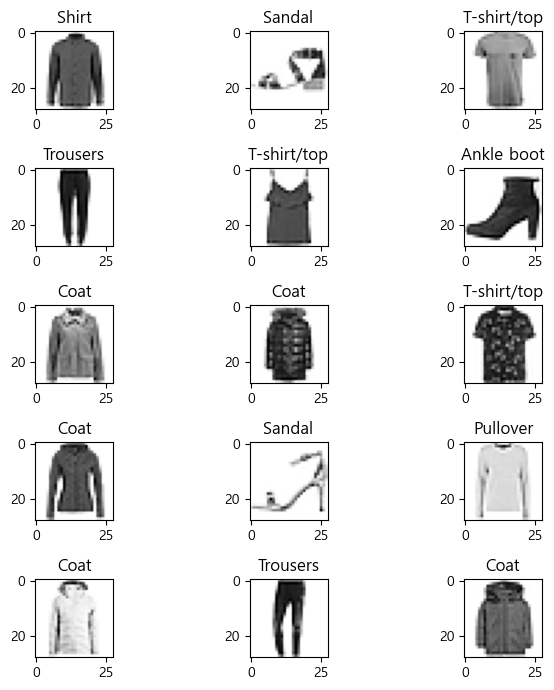

In [52]:
cnt = 15  # 확인할 이미지개수 (5배수)
plt.figure(figsize=(7,7))
for i in range(cnt):
    plt.subplot(5, int(cnt/5), i+1) # 5 줄로 나타낼 것이며, 이에 따라 열의 수를 맞춘다.
    plt.imshow(train_image[i], cmap='Greys')  # gray: 0-black, 255: white,  Greys: 0-white, 255-black
    label = class_names[y_train[i]]
    plt.title(label)
    
plt.tight_layout()
plt.show()

#### 하이퍼파라미터, 변수 설정

In [53]:
LEARNING_RATE = 0.001  # 학습률
# N_EPOCH = 100          # 에폭수
N_EPOCH = 20
N_BATCH = 1000         # 배치 사이즈

#### X, y  전처리
- y값 처리
    1. 다중 분류에서 label encoding 형식의 label을 one hot encoding 처리 ==> loss: categorical_crossentropy
    2. label encoding 형식의 label을 그대로 모델에 전달. => loss: sparse_categorical_crossentropy
        - one hot encoding 처리를 loss가 대신 한다.

- x값(이미지) 처리
    - dtype을 uint8에서 float32로 변환한다.
    - 0 ~ 1 정규화. X/255.0으로 나눈다.

In [54]:
X_train = train_image.astype('float32')/255.0
X_val = val_image.astype('float32')/255.0
X_test = test_image.astype('float32')/255.0

In [55]:
print(train_image.min(), train_image.max())
print(X_train.min(), X_train.max())

0 255
0.0 1.0


In [56]:
X_train.shape, X_val.shape, X_test.shape

((48000, 28, 28), (12000, 28, 28), (10000, 28, 28))

##### Dataset 생성

In [57]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                               .shuffle(X_train.shape[0]).batch(N_BATCH, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(N_BATCH)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)

In [58]:
# 에폭당 step 수 계산
len(train_dataset), len(val_dataset), len(test_dataset)

(48, 12, 10)

##### 모델 생성 및 컴파일

In [59]:
def get_model_fashion(lr=0.01):
    model = keras.Sequential()
    
    # input(28,28) => 2차원,
    #  Dense layer은 입력으로 1차원 배열을 받는다.
    ## 2차원을 1차원으로 변환 : Flatten layer.
    model.add(layers.Flatten(input_shape=(28, 28)))
    
    ### Hidden layer
    # Dense Layer의 Unit개수는 점점 줄여나가는 패턴을 사용.
    ## 출력 레이어의 unit 개수를 고려해서 Dense unit의 수를 결정한다.
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    
    # output layer - 다중 분류
    ## unit 개수 == class 개수(10)
    ### activation 함수 : softmax() ==> class 별 확률을 출력하도록 한다.
    model.add(layers.Dense(10, activation='softmax', name='output'))
    
    # 컴파일
    # 다중분류 loss함수:
#             y가 one hot encoding이 안된 경우: sparse_categorical_crossentropy 
                                              # (1. y를 원핫인코딩 처리, 2. loss 계산)
    
#             y를 one hot encoding 한 경우: categorical_crossentropy
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), 
                  loss='sparse_categorical_crossentropy',   
                  metrics=['accuracy']
                 )
    return model

In [60]:
model_fashion = get_model_fashion(LEARNING_RATE)
model_fashion.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 output (Dense)              (None, 10)                330       
                                                                 
Total params: 244522 (955.16 KB)
Trainable params: 244

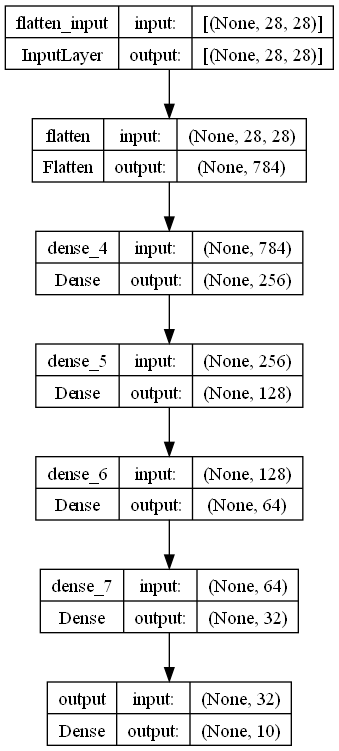

In [63]:
keras.utils.plot_model(model_fashion, show_shapes=True, to_file='model_fashion.png')

In [65]:
help(keras.utils.plot_model)

Help on function plot_model in module keras.src.utils.vis_utils:

plot_model(model, to_file='model.png', show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96, layer_range=None, show_layer_activations=False, show_trainable=False)
    Converts a Keras model to dot format and save to a file.
    
    Example:
    
    ```python
    input = tf.keras.Input(shape=(100,), dtype='int32', name='input')
    x = tf.keras.layers.Embedding(
        output_dim=512, input_dim=10000, input_length=100)(input)
    x = tf.keras.layers.LSTM(32)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)
    model = tf.keras.Model(inputs=[input], outputs=[output])
    dot_img_file = '/tmp/model_1.png'
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=T

##### Train(학습)

In [66]:
hist = model_fashion.fit(train_dataset, epochs=N_EPOCH, validation_data=val_dataset)

Epoch 1/20
48/48 [==============================] - 1s 13ms/step - loss: 1.0248 - accuracy: 0.6647 - val_loss: 0.6009 - val_accuracy: 0.7933
Epoch 2/20
48/48 [==============================] - 1s 13ms/step - loss: 0.5066 - accuracy: 0.8295 - val_loss: 0.4768 - val_accuracy: 0.8303
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4376 - accuracy: 0.8487 - val_loss: 0.4193 - val_accuracy: 0.8512
Epoch 4/20
48/48 [==============================] - 0s 9ms/step - loss: 0.3977 - accuracy: 0.8615 - val_loss: 0.3928 - val_accuracy: 0.8597
Epoch 5/20
48/48 [==============================] - 0s 9ms/step - loss: 0.3862 - accuracy: 0.8644 - val_loss: 0.3839 - val_accuracy: 0.8614
Epoch 6/20
48/48 [==============================] - 1s 10ms/step - loss: 0.3639 - accuracy: 0.8709 - val_loss: 0.3663 - val_accuracy: 0.8699
Epoch 7/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3395 - accuracy: 0.8796 - val_loss: 0.3613 - val_accuracy: 0.8679
Epoch 8/20
48/4

##### 결과 시각화
- 학습 시 epoch별 검증 결과를 시각화한다.

In [67]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
hist.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

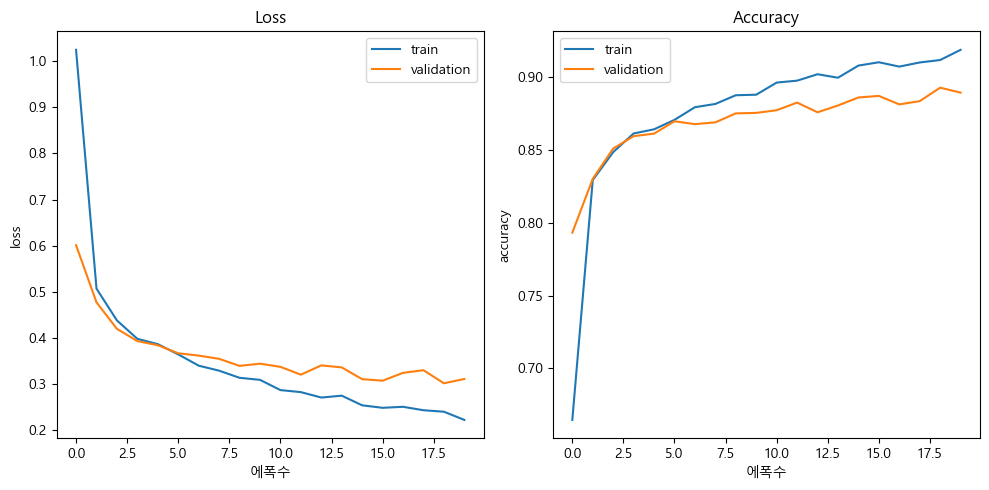

In [69]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, hist.history['loss'], label="train")
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('에폭수')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.epoch, hist.history['accuracy'], label='train')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('에폭수')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### 최종평가

In [72]:
# test set
loss, acc = model_fashion.evaluate(test_dataset)

10/10 [==============================] - 0s 5ms/step - loss: 0.3396 - accuracy: 0.8848


In [73]:
print(loss, acc, sep=" , ")

0.3395998775959015 , 0.8848000168800354


#### 모델저장

In [74]:
save_dir_fashion = 'saved_model/fashion_mnist_model'

In [75]:
model_fashion.save(save_dir_fashion)

INFO:tensorflow:Assets written to: saved_model/fashion_mnist_model\assets


INFO:tensorflow:Assets written to: saved_model/fashion_mnist_model\assets


#### 새로운 데이터 추론

In [76]:
# 저장된 모델을 loading해서 추론
saved_model_fashion = models.load_model(save_dir_fashion)
saved_model_fashion.evaluate(test_dataset)

10/10 [==============================] - 0s 5ms/step - loss: 0.3396 - accuracy: 0.8848


[0.3395998775959015, 0.8848000168800354]

In [77]:
new_X = X_test[1000:1010]
new_X.shape

(10, 28, 28)

In [78]:
pred = saved_model_fashion.predict(new_X)
pred.shape

1/1 [==============================] - 0s 48ms/step


(10, 10)

In [79]:
pred

array([[1.7180265e-01, 1.2263822e-05, 2.5423826e-03, 7.6530641e-04,
        4.3857744e-05, 2.4784460e-06, 8.2434613e-01, 1.9248737e-06,
        4.8138626e-04, 1.7429400e-06],
       [4.9867714e-04, 1.8638557e-05, 1.8174433e-04, 9.9799323e-01,
        1.8943242e-04, 2.7957485e-09, 1.1046862e-03, 8.1743032e-08,
        1.3476891e-05, 7.8046242e-10],
       [4.5922442e-07, 1.6927060e-13, 6.6011594e-08, 3.6964111e-14,
        8.7437509e-11, 9.9999464e-01, 2.7270816e-10, 1.7250346e-10,
        6.9399695e-09, 4.8471193e-06],
       [1.5300330e-06, 1.3759702e-11, 1.1212936e-06, 4.3250681e-12,
        7.6018452e-08, 9.9999654e-01, 7.6954265e-09, 6.3220462e-10,
        5.4679549e-07, 1.6602216e-07],
       [1.2195751e-03, 7.7896446e-05, 1.6020221e-01, 5.1458058e-04,
        8.4697478e-02, 2.1542231e-05, 7.5284708e-01, 1.2433454e-05,
        3.9874250e-04, 8.4851245e-06],
       [3.9960712e-02, 1.4827306e-02, 1.7270049e-01, 2.1777573e-01,
        3.6943468e-01, 2.9813471e-06, 1.4912346e-01, 3.16

In [80]:
# 모델 추론결과에 대한 후처리 작업
label = np.argmax(pred, axis=-1)
label_name = class_names[label]
proba = np.max(pred, axis=-1) 

## argmax() : max 값의 인덱스 반환
## max() : max 값 반환

label,  label_name, proba*100

(array([6, 3, 5, 5, 6, 4, 5, 9, 6, 3], dtype=int64),
 array(['Shirt', 'Dress', 'Sandal', 'Sandal', 'Shirt', 'Coat', 'Sandal',
        'Ankle boot', 'Shirt', 'Dress'], dtype='<U11'),
 array([82.434616, 99.799324, 99.999466, 99.99966 , 75.284706, 36.94347 ,
        99.999146, 99.644455, 44.94274 , 99.358215], dtype=float32))

In [81]:
for idx, (n, p) in enumerate(zip(label_name, proba), start=1):
    print(f"{idx}. {n} - {int(p*100)}%")

1. Shirt - 82%
2. Dress - 99%
3. Sandal - 99%
4. Sandal - 99%
5. Shirt - 75%
6. Coat - 36%
7. Sandal - 99%
8. Ankle boot - 99%
9. Shirt - 44%
10. Dress - 99%


In [83]:
class_names[y_test[1000:1010]]

array(['T-shirt/top', 'Dress', 'Sandal', 'Sandal', 'Shirt', 'T-shirt/top',
       'Sandal', 'Ankle boot', 'Shirt', 'Dress'], dtype='<U11')

## 위스콘신 유방암 데이터셋 - 이진분류(Binary Classification) 문제

- **이진 분류 문제 처리 모델의 두가지 방법**
    1. positive(1)일 확률을 출력하도록 구현
        - output layer: units=1, activation='sigmoid'
        - loss: binary_crossentropy
    2. negative(0)일 확률과 positive(1)일 확률을 출력하도록 구현 => 다중분류 처리 방식으로 해결
        - output layer: units=2, activation='softmax', y(정답)은 one hot encoding 처리
        - loss: categorical_crossentropy
        
- 위스콘신 대학교에서 제공한 종양의 악성/양성여부 분류를 위한 데이터셋
- Feature
    - 종양에 대한 다양한 측정값들
- Target의 class
    - 0 - malignant(악성종양)
    - 1 - benign(양성종양)

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

##### 데이터 로딩, train/validation/test set 나누기

In [13]:
X, y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

In [ ]:
np.unique(y)

In [ ]:
# Test set 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
# Train / Validation 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=0)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

#### 하이퍼파라미터, 변수 정의

In [ ]:
LEARNING_RATE = 0.001
N_EPOCH = 200
N_BATCH = 100
N_BATCH_VAL_TEST = 50

#### 데이터 전처리
- y (label) 처리
    - 이진 분류
        - 양성의 확률을 출력하도록 모델을 구성하는 경우 그대로 사용.
        - 양성일 확률, 음성일 확률을 출력하도록 모델을 구성하는 경우(다중분류 방식으로 처리) one hot encoding 처리한다.
- X (feature) 처리
    - 문자열(범주형): one hot encoding
    - 연속형(수치형): feature scaling

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#### Dataset 생성


In [ ]:
train_size = X_train_scaled.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))\
                               .shuffle(train_size).batch(N_BATCH, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val)).batch(N_BATCH_VAL_TEST)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test)).batch(N_BATCH_VAL_TEST)

#### model 생성, 컴파일

In [ ]:
X_train_scaled.shape

In [ ]:
from tensorflow.keras.metrics import Recall, Precision
def get_model_cancer(lr=0.01):
    model = keras.Sequential()
    #Hidden layer
    model.add(layers.Dense(32, activation='relu', input_shape=(30, )))
    model.add(layers.Dense(16, activation='relu'))
    # Output Layer
    # 이진분류(양성인가?): unit개수-1개(positive-양성- 확률), activation: "sigmoid"
    model.add(layers.Dense(1, activation='sigmoid', name='output_layer'))  # Layer이름 규칙: 변수명 규칙과 동일
    
    # 컴파일 - 이진분류의 loss함수: binary_crossentropy
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', Recall()])
    
    return model

In [ ]:
model_cancer = get_model_cancer(LEARNING_RATE)
model_cancer.summary()

In [ ]:
keras.utils.plot_model(model_cancer, show_shapes=True, to_file='model_cancer.png')

#### Train(학습)

In [ ]:
hist = model_cancer.fit(train_dataset, epochs=N_EPOCH, validation_data=val_dataset)

#### 결과 시각화

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, hist.history['loss'], label="train")
plt.plot(hist.epoch, hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.ylim(0, 0.1)
plt.xlabel('에폭수')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.epoch, hist.history['accuracy'], label='train')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('에폭수')
plt.ylabel('accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#### 최종평가

In [ ]:
loss, acc, recall = model_cancer.evaluate(test_dataset)
print(loss, acc, recall)

#### 모델저장

In [ ]:
save_dir_path = 'saved_model/cancer_model'

In [ ]:
model_cancer.save(save_dir_path)

#### 새로운 데이터 추론

In [ ]:
new_model = get_model_cancer(LEARNING_RATE)
new_model.evaluate(test_dataset)

In [ ]:
saved_model = models.load_model(save_dir_path)
saved_model.evaluate(test_dataset)

In [ ]:
new_X = X_test_scaled[:10]
pred = saved_model.predict(new_X)
pred.shape

In [ ]:
print(pred)
print(np.round(pred, 3))

##### 모델출력결과 후처리

In [ ]:
np.where(pred >= 0.5, '양성종양 - 1', '악성종양 - 0')

In [ ]:
y_test[:10]